# Dynamic Time Warp / KNN notebook
## Author: John O'Grady
### Objective:
The objective of this assignment is to implement and test a k-Nearest Neighbour (k-NN) classifier for time-series data. One of the big benefits of k-NN is that it can be used with data that is not in the normal feature vector format if a distance measure for that data can be found. Dynamic time warping (DTW) is such a measure for time series

### Importing libraries/data and setting up a DTW function

In [1]:
# Import relevant libraries
import pandas as pd # for handling data frames
import numpy as np # for formating arrays
from sklearn.neighbors import KNeighborsClassifier # KNN function in Sklearn for classificaiton
from sklearn import preprocessing # sklearn function for data normalisation
from sklearn.model_selection import train_test_split # Function splitting data into test and train for model evaluation
from sklearn.metrics import confusion_matrix # evaluation of accuracy
from sklearn.metrics import roc_curve, auc # roc curves
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay # help us to display confusion matrix and accuracy
from matplotlib import pyplot as plt # for plotting
from sklearn.metrics import classification_report # for reporting precision, recall, f1 , accuracy

In [2]:
# Import data required for the practical
# View the data output
time_series_data = pd.read_csv("UMD_TEST.txt", delim_whitespace=True, header=None) # Read in the file, no header, white spaced file
time_series_data.rename(columns={time_series_data.columns[0]: "Class" }, inplace = True) # rename the class column
time_series_data.head(1)# Check our the first rows

,Class,1,2,3,4,5,6,7,8,9,...,141,142,143,144,145,146,147,148,149,150
0,1.0,0.017644,0.030949,0.050555,0.044484,0.053277,0.041576,0.030947,0.027086,0.013764,...,0.024575,0.03378,0.026589,0.013932,0.024928,0.022589,0.038248,0.049838,0.053419,0.04042


In [3]:
# Check the dimensions of the original data
# needs to be 144 rows long and 151 ticks long (1 tick corresponds to Class labels)
#- as is specified in https://www.timeseriesclassification.com/description.php?Dataset=UMD
# Also, as data is all on the same scale (see webpage above, no need to normlaise)
# Also, DTW function (below) and Manhatten distance calculation deal in absolute distance and 
# Euclidean distance also squares distance values removing the threat posed by negative integers.
time_series_data.shape 

(144, 151)

In [4]:
# Reformatting and copying of data
# Extract the class values from the data
# Retain the time series data values
time_series_raw = time_series_data.copy() # make a copy of the data, need it below for a test of the dtw funciton
ts_classes = time_series_data.pop("Class").values # Pop off the labels
ts_values = time_series_data.values # retain the values
time_series_raw.shape, ts_classes.shape[0], ts_values.shape # View the dimensions

((144, 151), 144, (144, 150))

In [5]:
# Find out how many of each class are in the data
print("Class", "Number")
time_series_raw["Class"].value_counts()

Class Number


1.0    48
2.0    48
3.0    48
Name: Class, dtype: int64

#### Basic DTW Code
Code from https://towardsdatascience.com/dynamic-time-warping-3933f25fcdd  
This code implements a simple DTW measure between two series represented as lists.  
It allows for series of different lengths and has a `window` parameter that determines the amount of warping allowed.  
For series of different lengths, the minimum warping will be the difference in the lengths.  

In [6]:
def dtw(s, t, window): 
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)]) # warping cannot be less than the difference in lengths. 
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix[-1,-1]

## Task 1: 1-NN DTW
### __1.  Implement a simple 1-NN classifier for time-series data.__


In [7]:
# Initialise the funciton
def DTW_NN(query, df, window, class_train): 
    """query refers to the time series query of interest for classification.
       df refers to the numpy.ndarray which consists of all example points to compare query to.
       window refers to the window/warping paramater: integer.
       class_train refers to a vector with the class labels corresponding to the rows in the df paramater"""
    
    dtw_values = list() # set up an empty list for our dtw values. A new distance value will be appended at each iteration
    class_values = list()# set up an empty list for our class labels. A new value will be appended at each iteration
    
    for i in range(0, len(df)): # cycle through every row in the reference data frame
        train_array = df[i]
        train_class = class_train[i] # extract the class label for the training set
        dist = dtw(s=query,t=train_array,window=window) # calcualte the distance between a row's time-series data and the query
        dtw_values.append(dist) # append to our list
        class_values.append(train_class) # the class label for the row and the distance to the query are then stored in a dictionary
    
    # We now have 2 lists
        # 1: list of distances between a query and each row example
        # 2: the classification of every example data point in the same order as list 1
    
    # To calculate the 1-NN
    min_value = min(dtw_values) # find value which represents the smallest distance between the query and an example point in the df
    min_index = dtw_values.index(min_value) # get the index of that value
    Class_final = class_values[min_index] # get the class of the NN to the query
    return Class_final, min_value  # return the class label of the query and the distance to it's nearest point in the DF and index in the dtw_values.

#### Testing the 1NN-DTW Classifier

In [8]:
# Get data ready for testing the 1 NN
query_classes = time_series_raw.pop("Class") # get classes
queries = time_series_raw.values # get the values

# Try it on row 49
test_NN_class = query_classes[48] # get class
test_NN_data = queries[48] # get the time series data
func_test = DTW_NN(query = test_NN_data, df = queries, window = 0, class_train = query_classes) # run function
# look at output (class, distance to nearest point)
print(f'Class is {func_test[0]}, distance to nearest neighbour is {func_test[1]}')

Class is 2.0, distance to nearest neighbour is 0.0


#### Summary

We have built and tested a simple 1-NN DTW classifier for time-series data. The classifier takes in time series data from a query point and a training set of example points on which the query is compared to. It also takes in class labels corresponding to the rows in the training set. The classifier leverages a __dynamic time warp (DTW) function__ to calculate the distance between the query and all other example points in the data frame. It returns the class label of the nearest neighbour in addition to the distance between the query and its nearest neighbour. The amount of __warping__ can be specified with the `window` parameter. In the above case, the classifier identifies itself in the dataset and returns its correct label and a distance of 0

### 2. Test the performance of this classifier on the dataset provided in the file UMD_TEST.txt.

#### DTW method

In [9]:
# Need to split the dataset into test and train
# Set a reasonable test size of 40% (n = 58)
# This is a hold out testing strategy
ts_train, ts_test, ts_train_classes, ts_test_classes = train_test_split(ts_values, # time series values for each point
                                                                        ts_classes, # classes of the dataset to split on
                                                                        random_state=3345, # setting the seed for reproductibiliy 
                                                                        test_size=0.4 # test size of 40%
                                                                       )

In [10]:
# initialise a list which will collect our class values
predicted_classes = list()

# cycle through the test dataset
for i in range(0,len(ts_test)):
    query = ts_test[i]  # get the query of interest from the test set
    y_dash = DTW_NN(query = query, # our query data point
                    df = ts_train, # our training data on which to compare
                    window = 0, # window size of 0
                    class_train=ts_train_classes)[0] #  0 just to get the class here
    predicted_classes.append(y_dash) # append the predicted class to our list

    
predicted_classes = np.array(predicted_classes) # convert to a numpy array (may be important in confusion matrix) 

# View a subset of the results
print('Predicted Class:',predicted_classes[0:14])
print('     Real Class:',ts_test_classes[0:14])

Predicted Class: [2. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 2. 1. 3.]
     Real Class: [2. 1. 3. 1. 2. 2. 2. 1. 1. 1. 1. 3. 1. 3.]


In [11]:
# Evaluate the classifiaction using a *simple* confusion matrix
# Columns are predictions, rows are true labels
confusion = confusion_matrix(ts_test_classes, predicted_classes)
print("Confusion matrix:\n{}".format(confusion)) 

# Print to see how many samples of each class are in the test dataset
print("The total number of each class:", np.unique(ts_test_classes, return_counts = True))

Confusion matrix:
[[20  1  1]
 [ 0 19  0]
 [ 2  3 12]]
The total number of each class: (array([1., 2., 3.]), array([22, 19, 17], dtype=int64))


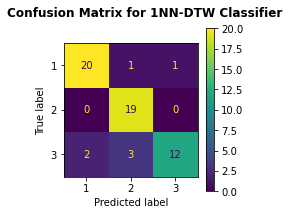

In [12]:
# Plot the confusion matrix
confusion = confusion_matrix(ts_test_classes, predicted_classes, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion, display_labels=[1,2,3])
fig, ax = plt.subplots(figsize=(3,3))
plt.suptitle("Confusion Matrix for 1NN-DTW Classifier", weight = "bold")
disp.plot(ax=ax)

In [13]:
# Use classification report function to get precision/recall/f1-score
report = classification_report(ts_test_classes, predicted_classes, target_names = ["1","2","3"]) # set labels to what we want
print("Evaluation Report for 1NN DTW evaluation:\n{}".format(report))  # print report to the screen

Evaluation Report for 1NN DTW evaluation:
              precision    recall  f1-score   support

           1       0.91      0.91      0.91        22
           2       0.83      1.00      0.90        19
           3       0.92      0.71      0.80        17

    accuracy                           0.88        58
   macro avg       0.89      0.87      0.87        58
weighted avg       0.89      0.88      0.88        58



#### Basic summary of test-train split, accuracy and dimensions
The overall accuracy of the 1NN DTW classifier is 0.88 with at a window size of 0. This accuracy was achieved with a test size of _n_ = 58 (40% of the UMD dataset). The test dataset is reasonably well balanced with _n_ = 22 Class 1, _n_ = 19 Class 2 and _n_ =17 Class 3 query points available and therefore, an accuracy metric is an appropriate metric to judge the classifier on. However, a more detailed description is provided below. 

#### Detailed summary of evaluation of 1NN DTW Classifier
Based on the confusion matrix and report above, the 1NN DTW function was 100% successful in classifying time series data with the pattern 2 motif as class 2. Hence the recall (out of all samples, what proportion of those identified as class 2 are class 2) is 100%. The precision (for a particular class, what proportion are correctly classified as that class) is lowest for class2 as there are some query points (total of 4) are misclassified as class 2 resulting in a precision value of 0.83.

The recall on datapoints with the class 3 was very poor (0.71) as 2 and 3 data points were predicted to belong to the class 1 and class 2 classes respectively, instead of class 3. The precision of the classifier for class 3 datapoints was good (0.92) however this should be interpreted cautiously as the overall sample size for this class is small (_n_ = 17)


Datapoints which possessed the class 1 motif had equal precision recall and f1-score, the latter being the highest amongst all the 3 classes. The f1-score is a single measure that trades off precision against recall, for a given level of balance. In other words, given that both the precision and recall were high and balanced and based on the data provided, the 1NN-DTW classifier was best at classifying datapoints with the class 1 motif.

### 3. Compare the 1-NN DTW performance with 1-NN Euclidean. 
- Using Scikitlearn implementation for 1-NN Euclidean

#### Manhattan distance - check to see if our DTW code is similar to Manhattan distance

In [14]:
# setting up the knn instance with neighbours = 1 
# p=1 is required for Manhattan
# set metric == "cityblock" to avoid ambiguity
Manhattan_KNN = KNeighborsClassifier(n_neighbors=1, p = 1, metric="cityblock") 
Manhattan_KNN.fit(ts_train, ts_train_classes) # fit it to the training data


# Predict classes in test set
class_predic_manhattan = Manhattan_KNN.predict(ts_test)

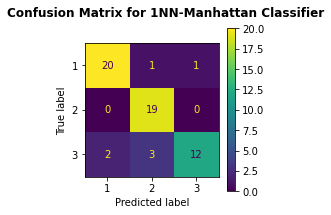

In [15]:
# Evaluate the classifiaction using a confusion matrix
confusion_manhattan = confusion_matrix(ts_test_classes, class_predic_manhattan)
disp = ConfusionMatrixDisplay(confusion_manhattan, display_labels=[1,2,3])
fig, ax = plt.subplots(figsize=(3,3))
plt.suptitle("Confusion Matrix for 1NN-Manhattan Classifier", weight = "bold")
disp.plot(ax=ax)

#### Euclidean Distance

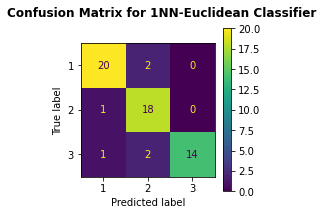

In [16]:
# setting up the knn instance with neighbours = 1, 
# p=2 is required for Euclidean distance
euclid_KNN = KNeighborsClassifier(n_neighbors=1, p = 2, metric = "euclidean")
euclid_KNN.fit(ts_train, ts_train_classes) # fit it to the training data
class_predic_euclid = euclid_KNN.predict(ts_test)

# ----------------------------------------------------------------------------------------------------
# Evaluate the classifiaction using a confusion matrix
confusion_euclid = confusion_matrix(ts_test_classes, class_predic_euclid)
disp = ConfusionMatrixDisplay(confusion_euclid, display_labels=[1,2,3])
fig, ax = plt.subplots(figsize=(3,3))
plt.suptitle("Confusion Matrix for 1NN-Euclidean Classifier", weight = "bold")
disp.plot(ax=ax)

In [17]:
# Get report of values
report = classification_report(ts_test_classes, class_predic_euclid, target_names = ["1","2","3"]) # set labels to what we want
print("Evaluation Report for 1NN Euclidean evaluation:\n{}".format(report))  # print report to the screen

Evaluation Report for 1NN Euclidean evaluation:
              precision    recall  f1-score   support

           1       0.91      0.91      0.91        22
           2       0.82      0.95      0.88        19
           3       1.00      0.82      0.90        17

    accuracy                           0.90        58
   macro avg       0.91      0.89      0.90        58
weighted avg       0.91      0.90      0.90        58



#### Summary of comparison of 1NN-DTW to 1NN-Euclidean
When comparing the performance of the 1NN-DTW classifier to a 1NN-Manhattan classifier, the accuracies are the same (with a window size of 0). Both classifiers achieve an overall accuracy of 0.88. 

The accuracy is slightly improved for a 1NN-Euclidean classifier (0.90) which seems to be superior at correctly classifying time series data which possess the class 3 time series motif. The precision and recall values are 0.08 and 0.09; higher than for the 1NN-DTW and 1NN-Manhattan classifiers. However, the recall on data with the class 2 motif has decreased by 0.05

#### Comparison of 1NN-DTW to 1NN-Manhattan
The accuracies are identical between the DTW and the manhattan classifier as the DTW function considers absolute distance between two points, not the straight line distance in the case of a euclidean classifier.

### 4. Find the best value for the window parameter for this dataset.

In [18]:
# Set up a dictionary
w_acc = dict()

# cycle through a range of values for warping
for w in range(0,15):
    # initialise a list for each iteration
    predicted_classes = list()
    
    # For each query point
    for i in range(0,len(ts_test)):
        
        # initialise the query
        query = ts_test[i] 
        # Get the predicted class based on our pre-defined function
        y_dash = DTW_NN(query = query, df = ts_train, window = w, class_train=ts_train_classes)[0] # just get the class here
        
        # Append the value to a list
        predicted_classes.append(y_dash)
    # Calculate the confusion matrix
    confusion = confusion_matrix(ts_test_classes, predicted_classes)
    # Get the accuracy
    acc = confusion[0][0] + confusion[1][1] + confusion[2][2]
    acc = acc / ts_test.shape[0]
    # Set the warping value = to the accuracy in the dictionary.
    w_acc[w] = round(acc,2)

In [19]:
# For each entry in the dictionary
for element in w_acc:
    # Print the key and value pair
    print(f'A window size of {element} yielded an overall accuracy of {w_acc[element]}')
print(f'The best window size for this data is {max(w_acc.items(), key=lambda x: x[1])[0]}')

A window size of 0 yielded an overall accuracy of 0.88
A window size of 1 yielded an overall accuracy of 0.88
A window size of 2 yielded an overall accuracy of 0.88
A window size of 3 yielded an overall accuracy of 0.93
A window size of 4 yielded an overall accuracy of 0.95
A window size of 5 yielded an overall accuracy of 0.97
A window size of 6 yielded an overall accuracy of 0.98
A window size of 7 yielded an overall accuracy of 0.97
A window size of 8 yielded an overall accuracy of 0.97
A window size of 9 yielded an overall accuracy of 0.97
A window size of 10 yielded an overall accuracy of 0.97
A window size of 11 yielded an overall accuracy of 0.97
A window size of 12 yielded an overall accuracy of 0.97
A window size of 13 yielded an overall accuracy of 0.97
A window size of 14 yielded an overall accuracy of 0.97
The best window size for this data is 6


#### Evaluating 1NN-DTW with the warping paramater set to 6

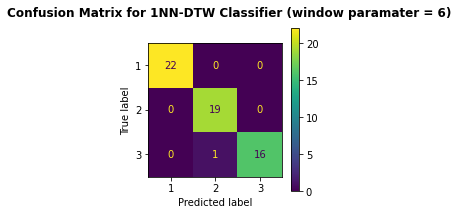

In [20]:
# View confusion matrix and evaluation metrics at a window size of 6
# Repeat as above but change window to 6
predicted_classes = list() # initialise a list which will collect our class values


for i in range(0,len(ts_test)): # cycle through the test dataset
    query = ts_test[i]  # get the array
    y_dash = DTW_NN(query = query, df = ts_train, window = 6, class_train=ts_train_classes)[0] #  0 just to get the class here
    predicted_classes.append(y_dash) # append the predicted class to our list
dtw_6_classes = np.array(predicted_classes) # convert to a numpy array (may be important in confusion matrix) 

# --------------------------------------------------------------------------------------------------------
# Confusion matrix
confusion_dtw = confusion_matrix(ts_test_classes, dtw_6_classes) # compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_dtw, display_labels=[1,2,3])
fig, ax = plt.subplots(figsize=(3,3))
plt.suptitle("Confusion Matrix for 1NN-DTW Classifier (window paramater = 6)", weight = "bold")
disp.plot(ax=ax)

In [21]:
# Get report of values
report = classification_report(ts_test_classes, dtw_6_classes, target_names = ["1","2","3"]) # set labels to what we want
print("Evaluation Report for 1NN-DTW Classifier (window paramater = 6) :\n{}".format(report))  # print report to the screen

Evaluation Report for 1NN-DTW Classifier (window paramater = 6) :
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        22
           2       0.95      1.00      0.97        19
           3       1.00      0.94      0.97        17

    accuracy                           0.98        58
   macro avg       0.98      0.98      0.98        58
weighted avg       0.98      0.98      0.98        58



#### Broad discussion on window size of 6
As is stated above, the best window size for this dataset is a window size of 6. This yielded an accuracy of 0.98 after which no further improvement was made. The __accuracy increased slowly as the amount of warping increased but decreased after a value of 6 and plateaued at an accuracy of 97__%. Moreover, as was mentioned above, as the dataset is reasonably balanced, accuracy is a suitable metric on which to judge this classifier on.

#### Detailed examination of evaluation report
The classifier is 100% correct at classifying time series data types with the class 1 motif having a precision, recall and f1 score of 1. The recall for time series data types with the class 2 motif is 1 and precision is 0.95. The precision for class 3 data types is 1 and recall is 0.95. The f1 score is equal for class 2 and class 3 time series data types. __In summary, out of all 58 query data points, with a window size of 6, the 1NN DTW Classifier only misclassified one query yielding an overall accuracy of 98%.__

## Task 2: k-NN DTW
### 1. Adapt the DTW code provided so that it can be incorporated  in a scikit-learn k-NN  classifier

In [22]:
# Metric paramater
#If metric is a callable function, it takes two arrays representing 1D vectors as inputs and 
    #must return one value indicating the distance between those vectors. 
    #This works for Scipy’s metrics, but is less efficient than passing the metric name as a string.
DTW_KNN_classifier = KNeighborsClassifier(n_neighbors= 1, 
                                          metric=dtw, # specify our dtw function as the metrix
                                          metric_params={"window":6}) # specify key paramaters in the function (key warping paramater)
DTW_KNN_classifier.fit(ts_train, ts_train_classes)

KNeighborsClassifier(metric=<function dtw at 0x00000268F056FA60>,
                     metric_params={'window': 6}, n_neighbors=1)

#### Summary of function
Here we have adapted the DTW code to fit into scikit-learn knn classifier. The function which enabled this was the metric paramater in the KNeighborsClassifier function. We can __modify specific paramaters__ of the user defined distance metric function such as the `window` parmater (here 6) by using the `metric_params`. We can also __alter the basic paramaters__ offered by the Scikit learn KNeighborsClassifier function such as `n_neightbours` (here 1). 

### 2. Test the performance of this classifier and compare with the 1-NN results from Task 1. Verify that the 1-NN results are consistent. 

#### Verify that 1NN results are consistent

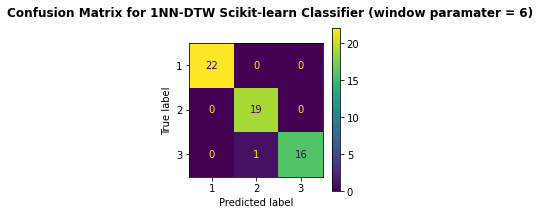

In [23]:
# Predict the class function on the test set
class_predic_dtw = DTW_KNN_classifier.predict(ts_test)
confusion_dtw = confusion_matrix(ts_test_classes, class_predic_dtw) # compute the confusion matrix
disp = ConfusionMatrixDisplay(confusion_dtw, display_labels=[1,2,3])
fig, ax = plt.subplots(figsize=(3,3))
plt.suptitle("Confusion Matrix for 1NN-DTW Scikit-learn Classifier (window paramater = 6)", weight = "bold")
disp.plot(ax=ax)

What we can see here is that for a window/warping size of 6 (optimal one for this dataset) and for classifying the test data based only on the nearest neighbor, the __results are identical to the DTW classifier implemented in Task 1.__ Hence, we have successfully implemented the DTW function into a scikit-learn knn classifier.

#### Performance of classifier: Compare with 1NN results

In [24]:
neighbors = [1,2,3,4,5,6,7,8] # list to cycle through
for n in neighbors:
    DTW_KNN_classifier = KNeighborsClassifier(n_neighbors= n, # neighbours consider
                                              metric=dtw, # specify our dtw function as the metric
                                              metric_params={"window":6}, # optimum window paramater for hold-out testing set
                                              weights="distance") # Weight vote based on location to data
    
    # Fit to our train
    DTW_KNN_classifier.fit(ts_train, ts_train_classes)
    # Predict on test set
    class_predic_dtw = DTW_KNN_classifier.predict(ts_test)
   
    # Calculate the accuracy - compare to true
    # X = test set
    # Y = true labels for X
    accu = DTW_KNN_classifier.score(ts_test, ts_test_classes) 
    accu = round(accu,4) # round the accuracy
    print(f'Setting a neighbour value of {n}, with a window size of 6 yielded an accuracy of {accu}') # print it to the screen  

Setting a neighbour value of 1, with a window size of 6 yielded an accuracy of 0.9828
Setting a neighbour value of 2, with a window size of 6 yielded an accuracy of 0.9828
Setting a neighbour value of 3, with a window size of 6 yielded an accuracy of 0.931
Setting a neighbour value of 4, with a window size of 6 yielded an accuracy of 0.9828
Setting a neighbour value of 5, with a window size of 6 yielded an accuracy of 0.9655
Setting a neighbour value of 6, with a window size of 6 yielded an accuracy of 0.9655
Setting a neighbour value of 7, with a window size of 6 yielded an accuracy of 0.9483
Setting a neighbour value of 8, with a window size of 6 yielded an accuracy of 0.9655


In general, the accuracy of the K-NN DTW classifier decreases slightly as the number of neighbours increases. Hence, __including more neighbours into the classification algorithm does not improve the overall accuracy of the classifier.__ 

Moreover based on the above analysis, by selecting the optimum value for the `window` paramater, it would appear that a key component in determining the effectiveness of this DTW classifier is infact the `window` paramater. 

Finally, to avoid instances where a tie was incurred (e.g. a queries nearest neighbour was an example point classed as 1 and another classed as class2), the `weights` paramater was specified to weight each neighbors vote based on how close they are to the query example to avoid random guessing (default).  

### 3. Compare with k-NN Euclidean

In [25]:
neighbors = [1,2,3,4,5,6,7,8] # list to cycle through
for n in neighbors: 
    # p=2 is required for Euclidean distance
    euclid_KNN = KNeighborsClassifier(n_neighbors=n, 
                                      p = 2,
                                      weights = "distance",# weight distance so that classes arent assigned as random
                                      metric= "euclidean") # metric of interest
    euclid_KNN.fit(ts_train, ts_train_classes) # fit it to the training data
    class_predic_euclid = euclid_KNN.predict(ts_test)
    accu = euclid_KNN.score(ts_test, ts_test_classes)
    accu = round(accu,4)
    print(f'Neighbour = {n}, Accuracy = {accu}')

Neighbour = 1, Accuracy = 0.8966
Neighbour = 2, Accuracy = 0.8966
Neighbour = 3, Accuracy = 0.8793
Neighbour = 4, Accuracy = 0.8966
Neighbour = 5, Accuracy = 0.8621
Neighbour = 6, Accuracy = 0.8621
Neighbour = 7, Accuracy = 0.8448
Neighbour = 8, Accuracy = 0.8276


The KNN Euclidean classifier also decreases in accuracy as the number of neighbours increases but returns to its maximum accuracy at n = 4 before decreasing again. 

The trend overall is similar to the k-NN DTW classifier in that accuracy decreases as the number of neighbours included increases. 

Nonetheless, the overall accuracy for classifying the test set is still quite high (>0.82 for all neighbours tested) but lower in comparison to the k-NN DTW classifier (> 0.93 for all neighbours tested). 

However, for both classifiers, it appears a neighbor size of 1 is the optimum number to use for this dataset.

#### Cross Validation Comparison
The hold out strategy conduct heretofore may be limited for a number of reasons. 

- Accuracy may be underestimated/overestimated due to an unfortuante/fortunate split in the data. 
- Moreover, in hold out testing, accuracy will increase as training size increases, hence cross fold validation may be more suitable to compare models as we have lost 40% of our data to the test set already. 
- Also, cross validation gives us a __stable estimate__ of accuracy as we are averaging accross multiple folds and are hence reducing the variance in the accuracy estimate. It could also be possible to employ a leave one out cross validation but the computational time required to do this, especially when adjusting the `warping` paramater is high.

In [26]:
from sklearn.model_selection import cross_val_score, KFold
folds = 8
# Set up a dictionary
w_acc = dict()

# cycle through a range of values for warping
for w in range(0,15):
    # create KNN objects based on results heretofore
    # Set n = 1 as above this was shown to be the best performing neighbor value for both datasets
    euclid_KNN_CV = KNeighborsClassifier(n_neighbors=1, p = 2, metric = "euclidean")
    DTW_KNN_CV = KNeighborsClassifier(n_neighbors= 1, metric=dtw, # specify our dtw function as the metric
                                   metric_params={"window":w} # keep assess warping, too long to test every possible window
                                     )  

    models = [euclid_KNN_CV, DTW_KNN_CV] # set up models
    names = ["1NN-Euclidean", "1NN-DTW      "] #set up names for reporting 
    mod = -1
    for m in models:
        mod += 1
        name = names[mod]
        acc_scores = cross_val_score(m, # model
                                     ts_values, # all the values - these will be split 
                                     ts_classes, # all the classes  - these will be split
                                     scoring="accuracy", n_jobs = 5)
        if mod == 1:
            w_acc[w] = round(acc_scores.mean(), 3)
        if w == 0:
            print(f'{folds} x CV {name} {round(acc_scores.mean(),3)}')
        elif w == 14 and mod == 1:
            print(f'{folds} x CV {name} with optimum warping ({max(w_acc.items(), key=lambda x: x[1])[0]}) {max(w_acc.items(), key=lambda x: x[1])[1]}')

8 x CV 1NN-Euclidean 0.832
8 x CV 1NN-DTW       0.728
8 x CV 1NN-DTW       with optimum warping (11) 0.902


The overall 8 Fold cross validation accuracy of the 1NN-DTW with one neighbour and a warping value of 0 was 0.728 which is significantly less than the accuracy obtained from the 1NN-Euclidean Classifier (0.832). However, with an optimum wapring value of 11, the overall accuracy of the 1NN-DTW (0.902) is far better than the 1NN-Euclidean classifier. Note, a `n-neighbor` value of 1 was selected here for comparison based on previous analysis above. It is interesting that the optimum warping paramater value changed for this CV task. 

However, the overall average accuracy is lower in comparison to the hold-out-testing approach which we have delt with heretofore for both models which would suggest that the initial hold-out-testing approach overestimated the accuracy of the classifiers. 

This accuracy (0.902) of the DTW classifier and the cross-validation accuracy of the Euclidean classifier (0.832) are probably more realistic estimates of each model's accuracy respectively.

## Conclusion
- We have built a 1NN-DTW classifier which can classify time series data via the implementation of a Dynamic time warp function. 
- We implemented the function as a scikit-learn K-NN classifier and compared it to a 1NN Manhattan and 1NN Euclidean classifier. We found that the accuracy of the 1NN-DTW classifier was identical to the 1NN Manhattan classifier as the original DTW function calculates the _absolute_ distance between 2 points and not the straight line distance as is employed in a euclidean classifyer.
- We evaluated the performance of the model using a range of evaluation metrics, including overall accuracy and for each class, the recall, precision and f1 score. We also compared the performance of the 1NN-DTW to that of a 1NN-Euclidean and noted that the accuracy was better in the Euclidean classifier.
- We noted that based on the test-train split via the hold-out testing strategy employed, the optimum `warping` paramater for the data was 6.
- We observed that increasing the number of neighbours using the `n_neighbours` paramater for both the DTW and Euclidean KNN classifiers resulted in an overall decrease in accuracy. Overall, the DTW function with its adjusted `warping` paramater was more accurate at classifying unseen data correctly in comparison to the Euclidean function.
- To mitigate against instances where the training set was too small and if the test-train split resulted in an under/overestimate of accuracy, we conducted 8-fold cross validation on the data set and noted that the accuracy of the 1NN-DTW classifier still out performed the accuracy estiamtes from the 1NN-Euclidean function but the overall accuracy was lower than when comparing to the hold-out testing strategy employed earlier. We also observed that the optimal `window` paramater for the 1NN-DTW function was altered to 11 in the CV scenario.